In [ ]:
#Imports for the following experiment:
!pip install rouge
import pandas as pd
from rouge import Rouge
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
# Download NLTK resources
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Path to Excel file on Google Drive
file_path = "./Prompts_answers.xlsx"
# Read the Excel file
df = pd.read_excel(file_path)
print(df.head())

   Prompt ID Emotional Tone  \
0          1        Neutral   
1          2            Sad   
2          3          Angry   
3          4         Happy    
4          5      Stressed    

                                              Prompt  \
0           "How much water should I drink daily?"\n   
1  "I've been feeling really down lately and can'...   
2  "I get so angry and worked up during the day, ...   
3  I'm feeling great and want to ensure I stay hy...   
4  I'm always anxious about whether I'm drinking ...   

                                         IdealAnswer  \
0                                                NaN   
1  eeling down can indeed make it harder to care ...   
2  It's understandable that anger and a hectic da...   
3  "Great to hear that you're feeling upbeat and ...   
4  "Feeling anxious about hydration is common, bu...   

                                      GeminiResponse  
0  There isn't a one-size-fits-all answer to how ...  
1  I understand you're feelin

# 1.Sentiment Analysis

In [ ]:
# Preprocessing
df_filtered = df.dropna(subset=['IdealAnswer'])
# Normalize emotional tone for consistency in comparison.Remove spaces and convert the text to lowercase
df_filtered['Emotional Tone'] = df_filtered['Emotional Tone'].str.strip().str.lower()

# Initialize Sentiment Intensity Analyzer for sentiment analysis.
sia = SentimentIntensityAnalyzer()

# Prepare a structure to hold sentiment and emotional word usage scores for analysis.
emotion_scores = defaultdict(lambda: {
    'gemini_response': {'sentiment_score': 0, 'neg': 0, 'neu': 0, 'pos': 0, 'count': 0},
    'ideal_answer': {'sentiment_score': 0, 'neg': 0, 'neu': 0, 'pos': 0, 'count': 0},
    'prompt': {'sentiment_score': 0, 'neg': 0, 'neu': 0, 'pos': 0, 'count': 0}
})

# Function for calculating sentiment scores for given text.
def calculate_sentiment(text):
    # Calculate the sentiment polarity scores
    scores = sia.polarity_scores(text)
    # Return the compound sentiment score along with individual sentiment components.
    return scores['compound'], scores['neg'], scores['neu'], scores['pos']

# Analyze sentiment for each row , compare responses, ideal answers, and prompts.
for index, row in df_filtered.iterrows():
    emotion = row['Emotional Tone']
    gemini_response, ideal_answer, prompt = row['GeminiResponse'], row['IdealAnswer'], row['Prompt']

    # Calculate sentiment scores for each text component.
    gemini_sentiment = calculate_sentiment(gemini_response)
    ideal_sentiment = calculate_sentiment(ideal_answer)
    # The sentiment of the prompt was calculated for exploratory purposes and was not used for the later stages of analysis
    prompt_sentiment = calculate_sentiment(prompt)

    # Aggregate the calculated sentiment scores by emotional tone for analysis.
    for category, sentiment in zip(['gemini_response', 'ideal_answer', 'prompt'], [gemini_sentiment, ideal_sentiment, prompt_sentiment]):
        for score_type, value in zip(['sentiment_score', 'neg', 'neu', 'pos'], sentiment):
            emotion_scores[emotion][category][score_type] += value
        emotion_scores[emotion][category]['count'] += 1

# Summarize and calculate overall sentiment scores for comparison.
overall_scores = {}
for emotion, scores_dict in emotion_scores.items():
    overall_scores[emotion] = {category: {score_type: value / scores_dict[category]['count']
                                          for score_type, value in category_scores.items() if score_type != 'count'}
                               for category, category_scores in scores_dict.items()}

# Display the aggregated sentiment analysis results.
# Print or return overall scores
print("Overall Scores:")
for emotion, scores_dict in overall_scores.items():
    print(f"{emotion}:")
    print(f"  Gemini Response - Sentiment Score: {scores_dict['gemini_response']['sentiment_score']:.3f}, Negative Score: {scores_dict['gemini_response']['neg']:.3f}, Neutral Score: {scores_dict['gemini_response']['neu']:.3f}, Positive Score: {scores_dict['gemini_response']['pos']:.3f}")
    print(f"  Ideal Answer    - Sentiment Score: {scores_dict['ideal_answer']['sentiment_score']:.3f}, Negative Score: {scores_dict['ideal_answer']['neg']:.3f}, Neutral Score: {scores_dict['ideal_answer']['neu']:.3f}, Positive Score: {scores_dict['ideal_answer']['pos']:.3f}")
    print(f"  Prompt          - Sentiment Score: {scores_dict['prompt']['sentiment_score']:.3f}, Negative Score: {scores_dict['prompt']['neg']:.3f}, Neutral Score: {scores_dict['prompt']['neu']:.3f}, Positive Score: {scores_dict['prompt']['pos']:.3f}")
    print()

<ipython-input-6-a2d419ecb696>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Emotional Tone'] = df_filtered['Emotional Tone'].str.strip().str.lower()


Overall Scores:
sad:
  Gemini Response - Sentiment Score: 0.883, Negative Score: 0.047, Neutral Score: 0.730, Positive Score: 0.223
  Ideal Answer    - Sentiment Score: 0.872, Negative Score: 0.042, Neutral Score: 0.745, Positive Score: 0.213
  Prompt          - Sentiment Score: 0.343, Negative Score: 0.069, Neutral Score: 0.693, Positive Score: 0.238

angry:
  Gemini Response - Sentiment Score: 0.674, Negative Score: 0.057, Neutral Score: 0.780, Positive Score: 0.163
  Ideal Answer    - Sentiment Score: 0.372, Negative Score: 0.064, Neutral Score: 0.798, Positive Score: 0.138
  Prompt          - Sentiment Score: -0.182, Negative Score: 0.144, Neutral Score: 0.772, Positive Score: 0.084

happy:
  Gemini Response - Sentiment Score: 0.996, Negative Score: 0.023, Neutral Score: 0.712, Positive Score: 0.265
  Ideal Answer    - Sentiment Score: 0.963, Negative Score: 0.016, Neutral Score: 0.728, Positive Score: 0.256
  Prompt          - Sentiment Score: 0.805, Negative Score: 0.000, Neutral

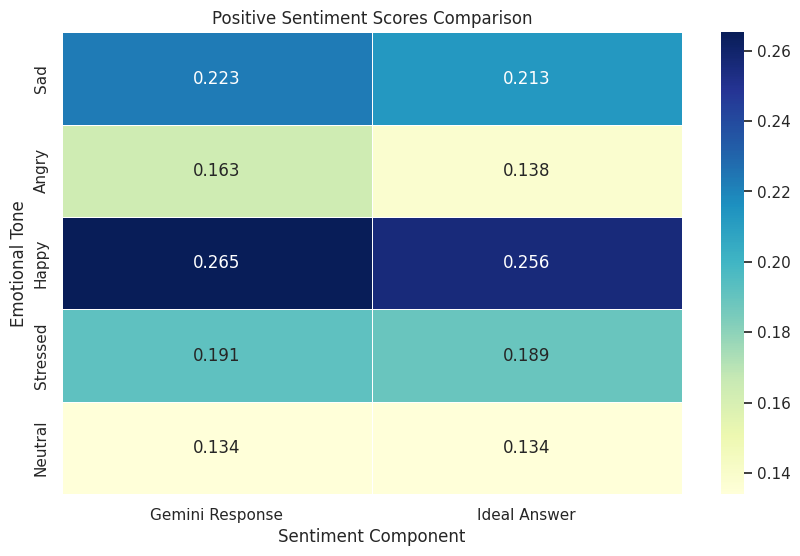

In [ ]:
# Graph for Positive Sentiment Scores Comaprison
# Extract positive sentiment scores for Gemini's response and ideal answer.
gemini_positive_scores = [overall_scores[emotion]['gemini_response']['pos'] for emotion in overall_scores]
ideal_answer_positive_scores = [overall_scores[emotion]['ideal_answer']['pos'] for emotion in overall_scores]

# Create a heatmap.
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.heatmap([[gp, ip] for gp, ip in zip(gemini_positive_scores, ideal_answer_positive_scores)],
                 cmap="YlGnBu", annot=True, fmt=".3f", linewidths=.5,
                 xticklabels=['Gemini Response', 'Ideal Answer'],
                 yticklabels=[emotion.capitalize() for emotion in overall_scores.keys()])
plt.title('Positive Sentiment Scores Comparison')
plt.xlabel('Sentiment Component')
plt.ylabel('Emotional Tone')
plt.show()


# 2 Rouge score

In [ ]:
# Initialize ROUGE with selected metrics (ROUGE-1, ROUGE-L)
rouge = Rouge(metrics=['rouge-1', 'rouge-l'])

# Filter out rows with 'Neutral' emotional tone and remove rows with missing values in certain columns
df_filtered = df[df['Emotional Tone'] != 'Neutral'].dropna(subset=['GeminiResponse', 'IdealAnswer'])

# Initialize dictionary to store ROUGE scores for each emotional tone
emotion_scores = {
    'Sad': [],
    'Angry': [],
    'Happy': [],
    'Stressed': []
}

# Function to calculate and append ROUGE scores for each row in the DataFrame
def calculate_and_append_scores(row):
    emotion = row['Emotional Tone'].strip()  # Extract emotional tone from the row
    gemini_response = row['GeminiResponse'].strip()  # Extract Gemini response from the row
    ideal_answer = row['IdealAnswer'].strip()  # Extract ideal answer from the row

    # Check if both Gemini response and ideal answer are non-empty strings
    if gemini_response and ideal_answer:
        # Calculate ROUGE scores for the current row and append to the corresponding emotion's scores list
        scores = rouge.get_scores(gemini_response, ideal_answer, avg=True)
        emotion_scores[emotion].append(scores)

# Apply the function to each row in the filtered DataFrame
df_filtered.apply(calculate_and_append_scores, axis=1)

# Calculate average scores for each emotion
average_scores_by_emotion = {emotion: {
    'rouge-1': {'f': 0},
    'rouge-l': {'f': 0}
} for emotion in emotion_scores}

# Iterate through each emotion and its corresponding list of ROUGE scores
for emotion, scores_list in emotion_scores.items():
    # Iterate through each set of ROUGE scores in the list
    for scores in scores_list:
        # Accumulate the ROUGE scores for each metric ('rouge-1', 'rouge-l')
        for key in scores:
            if key in average_scores_by_emotion[emotion]:
                average_scores_by_emotion[emotion][key]['f'] += scores[key]['f']
    num_scores = len(scores_list)  # Calculate the number of scores for the current emotion
    # Calculate the average ROUGE scores for each metric for the current emotion
    for key in average_scores_by_emotion[emotion]:
        average_scores_by_emotion[emotion][key]['f'] /= num_scores

# Compute overall average ROUGE scores across all emotions
all_scores = [score for sublist in emotion_scores.values() for score in sublist]
overall_average_scores = {
    'rouge-1': {'f': 0},
    'rouge-l': {'f': 0}
}

# Iterate through each set of ROUGE scores in the combined list
for scores in all_scores:
    # Accumulate the ROUGE scores for each metric ('rouge-1', 'rouge-l')
    for key in scores:
        if key in overall_average_scores:
            overall_average_scores[key]['f'] += scores[key]['f']
num_all_scores = len(all_scores)  # Calculate the total number of scores
# Calculate the average ROUGE scores for each metric across all emotions
for key in overall_average_scores:
    overall_average_scores[key]['f'] /= num_all_scores

# Print or return average_scores_by_emotion and overall_average_scores as needed
print("Average Scores by Emotion:", average_scores_by_emotion)
print("Overall Average Scores:", overall_average_scores)


Average Scores by Emotion: {'Sad': {'rouge-1': {'f': 0.30882397137730533}, 'rouge-l': {'f': 0.2865210692730537}}, 'Angry': {'rouge-1': {'f': 0.2746319555784651}, 'rouge-l': {'f': 0.2516850806943643}}, 'Happy': {'rouge-1': {'f': 0.310491249065878}, 'rouge-l': {'f': 0.2907975609558322}}, 'Stressed': {'rouge-1': {'f': 0.30688472933352867}, 'rouge-l': {'f': 0.28216138899509696}}}
Overall Average Scores: {'rouge-1': {'f': 0.3000049927755777}, 'rouge-l': {'f': 0.27761537336183284}}


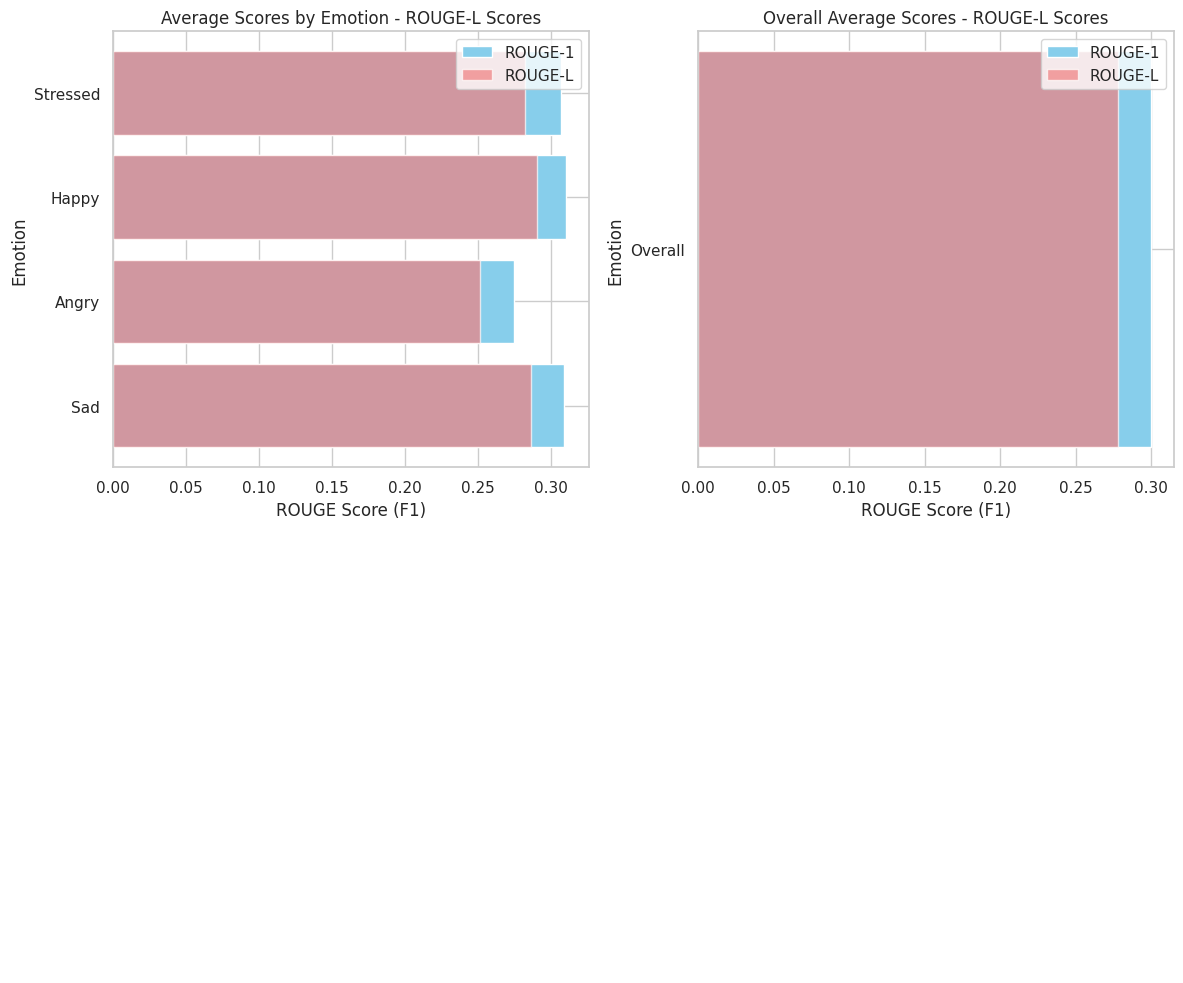

In [ ]:
# Graphs for Rouge Scores presentation
# Function to plot ROUGE scores
def plot_rouge_scores(scores_dict, title, ax):
    # Extract emotions and their corresponding ROUGE scores
    emotions = list(scores_dict.keys())
    rouge_1_scores = [scores_dict[emotion]['rouge-1']['f'] for emotion in emotions]
    rouge_l_scores = [scores_dict[emotion]['rouge-l']['f'] for emotion in emotions]

    # Plot ROUGE-1 scores
    ax.barh(emotions, rouge_1_scores, color='skyblue', label='ROUGE-1')
    ax.set_xlabel('ROUGE Score (F1)')
    ax.set_ylabel('Emotion')
    ax.set_title(f'{title} - ROUGE-1 Scores')
    ax.legend()

    # Plot ROUGE-L scores
    ax.barh(emotions, rouge_l_scores, color='lightcoral', label='ROUGE-L', alpha=0.7)
    ax.set_xlabel('ROUGE Score (F1)')
    ax.set_ylabel('Emotion')
    ax.set_title(f'{title} - ROUGE-L Scores')
    ax.legend()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot average ROUGE scores by emotion
plot_rouge_scores(average_scores_by_emotion, 'Average Scores by Emotion', axs[0, 0])

# Plot overall average ROUGE scores
plot_rouge_scores({'Overall': overall_average_scores}, 'Overall Average Scores', axs[0, 1])

# Hide the empty subplot
axs[1, 0].axis('off')
axs[1, 1].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
